In [1]:
# import packages
import numpy as np
import math
import matplotlib.pyplot as plt

import astropy.units as u
import astropy.constants as const

## Two-body dynamics: setting up Runge-Kutte method

In [16]:
def f(rs, **kwargs):
    """
    Evaluate the second derivative of the position vector in 2D.
    
    Inputs:  array with x-, y- components of the position vector
    Returns: array of x-,y- components of acceleration 
             evaluated at these points
    """
        
    # position of mass1, mass2    
    x1, y1 = rs[0], rs[1]  
    x2, y2 = rs[2], rs[3] 
    r = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    
    # x, y components of Acceleration a(t) = x''(t), which is also v'(t)
    ax1 = G*m2*(x2 - x1)/r**3    
    ay1 = G*m2*(y2 - y1)/r**3    
    ax2 = G*m1*(x1 - x2)/r**3    
    ay2 = G*m1*(y1 - y2)/r**3    
    
    return np.array([ax1, ay1, ax2, ay2], float)


In [17]:
def get_f(r, f):
    """
    Calculate updated x, y, vx, vy for each particle using a function 
        f(x,y,t) = v'(t)
    
    Inputs:
        r, 1-D array [x1,y1,x2,y2,vx1, vy1, vx2, vy2]
        
    Returns:
        fxy, 1-D array v(t), f(x,y,t)
        
    """
    
    x1, y1 = r[0], r[1]
    vx1, vy1 = r[4], r[5]
    x2, y2 = r[2], r[3]
    vx2, vy2 = r[6], r[7]
    
    fxy = np.array([vx1, vy1, vx2, vy2])
    fv = f(np.array([x1, y1, x2, y2]))
    # print(fv)
    
    return np.array(np.concatenate([fxy, fv]))
    

In [18]:
def get_energy(r, vi):
    """
    Calculate total energy for two masses
    
    Inputs:
        r, 1-D array of (x1, y1, x2, y2)
        vi, 1-D array of (vx1, vy1, vx2, vy2)
    Returns:
        energy, v**2/2 - mu/r
    
    """
    
    x1, y1, x2, y2 = r
    vx1, vy1, vx2, vy2 = vi
    
    r12 = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    v12 = np.sqrt((vx2 - vx1)**2 + (vy2 - vy1)**2)
    
    # vve = 0.5*v12**2 - mu/r12  # vis-viva (not right units)
    E = 0.5*mu*v12**2 - G*m1*m2/r12  # total energy
    
    return E
    

In [19]:
def get_err(truth, computed):
    """Calculate relative error"""
    if truth == 0.:
        print("using alt err")
        err = truth - computed
    else: 
        err = (truth - computed)/truth
    return err

In [61]:
def rk4(t0, tmax, r0, phi0, dphi0, dr0, f, h, err_tol):
    """
    Calculate orbit of a body about center of mass using 4th-order Runge-Kutte
    method.
    
    Inputs:
      t0, tmax: start, end time of simulation, Myr
      r0, phi0: initial position, angle of reduced mass, mu
      dphi0, dr0: initial angular, radial velocity of mu
      f: function for getting vx', vy'
      h: time interval
      err_tol: amount of allowed deviation from r_ref
    
    Returns:
      R: 2-D array of x1,y1,x2,y2 coordinates at each step
      err: relative error of total Energy of system
      
    """
    
    # Initialize arrays for time, position vector, & velocity vector
    ti = t0
    t = np.array(ti)
    
    x0 = r0 * np.cos(phi0)
    y0 = r0 * np.sin(phi0)
    vx0 = -r0 * np.sin(phi0)*dphi0 + np.cos(phi0)*dr0
    vy0 = r0 * np.cos(phi0)*dphi0 + np.sin(phi0)*dr0
    
    # convert from one-body reduced-mass to two-body problem
    x1, y1 = (mu/m1)*x0, (mu/m1)*y0 
    x2, y2 = -(mu / m2)*x0, -(mu / m2)*y0 
    vx1, vy1 = (mu/m1)*vx0, (mu/m1)*vy0 
    vx2, vy2 = -(mu / m2)*vx0, -(mu / m2)*vy0 
     
    # initialize arrays of positions at each step
    ri = np.array([x1, y1, x2, y2], float)
    
    # initialize arrays of velocities at each step
    vinit = np.array([vx1, vy1, vx2, vy2], float)
    vi = vinit
    v_ = np.array([vi]) # Initial vx, vy
    
    # initialize position-velocity mega-vector
    r = np.concatenate([ri,vi])
    R = np.array([r])
    
    debug = False
    
#     # Initialize steps for error check for circular orbit
#     r_check = np.sqrt(r[0]**2 + r[1]**2)  # current radius, r
#     rel_err = (r_ref - r_check)/r_ref

    # track relative error between initial Energy, calculated Energy 
    E_now = get_energy(ri, vi)
    # total energy of system, E = KE + PE
    E_ref = 0.5*mu*(vx0**2 + vy0**2) - G*m1*m2/r0
    
    rel_err = get_err(E_ref, E_now)
    #print(f"t=0: E_ref: {E_ref}, rel_err: {rel_err}")
    err = np.array([rel_err])
    global E
    E = np.array([E_now])
    
    # solve eqns of motion using R-K method
    while np.abs(rel_err) < err_tol:
        # break if t = tmax
        if ti > tmax:
            if debug: print(f"Time: {ti} > {tmax}")
            break
        else:
            # calculate r(t), r'(t)
            
            # compute k1, k2, k3, k4 for r
            k1  = h*get_f(r, f)
            k2 = h*get_f(r + k1*0.5, f) 
            k3 = h*get_f(r + k2*0.5, f) 
            k4 = h*get_f(r + k3, f)  

            # update ti, Ri
            ti += h
            r += (1/6)*(k1 + 2*k2 + 2*k3 + k4)

            # calculate new rel error
            rel_err = get_err(E_ref, get_energy(r[:4], r[4:]))

            # save new ri to r
            t = np.append(t, ti)
            R = np.append(R, np.array([r]), axis=0)
            err = np.append(err, rel_err) # relative error
            E = np.append(E, get_energy(r[:4], r[4:]))  # total energy
            
    # components of cartesian coords
    # R: [x1, x2, y1, y2]
    X = R[:,[0,2]]  # x1, x2
    Y = R[:,[1,3]]  # y1, y2
    #v_ = R[:,[4:,]]  # vx1, vy1, vx2, vy2
    v_ = R[:,4:]
    # show error
    print(f"E_ref = {E_ref}, |mean(E)| = {np.abs(np.mean(E))}")
    
    return t, X, Y, v_, err


In [59]:
# runtime initial conditions
t0, tmax = 0, 800 # 5000
h = 1 # 1e-3 Myr

# UNITS: kpc, Msun, Myr
# constants
G = (const.G).to(u.kpc**3 * u.Msun**-1 * u.Myr**-2).value # kpc^3/Msun/Myr

# orbit parameters
m1 = 1e12 # Msun
m2 = 1e12 # Msun
M = m1 + m2
mu = m1*m2 / M

# can get a = (G*M*T**2/(4*np.pi**2))**(1/3)
rmin = 25 # kpc
a = rmin   # semi-major axis (kpc, Kepler's Law)
ecc = 1. # 0.5

# define values for p, error calculation
if ecc == 1.:      # parabolic orbit
    print("parabolic orbit")
    p = 2 * rmin  
    err_tol = 1e10  # arbitrary value because E = 0
elif (ecc > 0.) & (ecc < 1.): # closed orbit, elliptical
    print("elliptical orbit")
    p = a * (1 - ecc**2)
    err_tol = 1e-5
else: # closed orbit, circular
    print("circular orbit")
    p = a
    err_tol = 1e-5


# choose initial position, motion of reduced-mass galaxy pair relative to 
#    semi-major axis or axis of closest approach
phi0 = 0.5*np.pi # np.pi*(2*np.random.rand() - 1) 
r0 = p / (1 + ecc * np.cos(phi0))
dphi0 = np.sqrt(G*M*p) / r0**2
dr0 = ecc * r0**2 * np.sin(phi0) * dphi0 / p

print(f"initial r0, phi0: {r0:.5} kpc, {phi0:.5} rad")

parabolic orbit
initial r0, phi0: 50.0 kpc, 1.5708 rad


In [62]:
t, X, Y, v_, err = rk4(t0, tmax, r0, phi0, dphi0, dr0, f, h, err_tol)
print(f"runtime: {t[-1]} kpc")

E_ref = 1.52587890625e-05, |mean(E)| = 6.37734529205094
runtime: 801 kpc


error at 801 Myr: 4.34779e+05


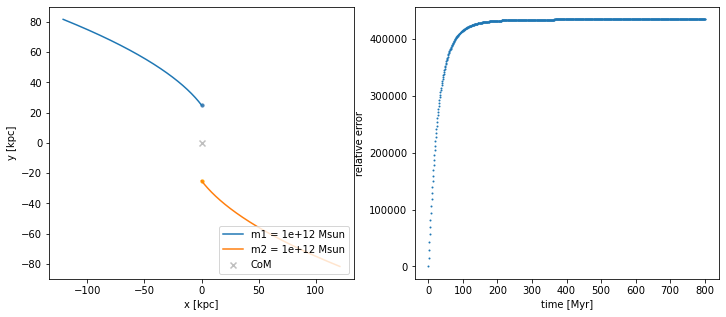

In [67]:
fig = plt.figure(figsize=(12,5))
ax1 = fig.add_subplot(121, aspect='auto')
# ax1.scatter(X[:,0], Y[:,0], s=1, label="m1")
# ax1.scatter(X[:,1], Y[:,1], s=1, label="m2")
plt.scatter(0,0, marker='x', color='grey', alpha=0.5, label=r'CoM')
plt.scatter(X[0,0], Y[0,0], s=10, c='steelblue') # initial position
plt.scatter(X[0,1], Y[0,1], s=10, c='orange') # initial position
plt.plot(X[:,0], Y[:,0], label=f"m1 = {m1:.3} Msun")
plt.plot(X[:,1], Y[:,1], label=f"m2 = {m2:.3} Msun")
ax1.set_xlabel("x [kpc]"), ax1.set_ylabel("y [kpc]")
plt.legend(loc='lower right')

ax2 = fig.add_subplot(122,aspect='auto')
ax2.scatter(t, err, s=1)
#ax2.set_ylim(err_tol*np.array([-1,1]))
ax2.set_xlabel("time [Myr]"), ax2.set_ylabel("relative error")
print(f"error at {t[-1]} Myr: {err[-1]:.6}")

(Text(0.5, 0, '$v_{x}$'), Text(0, 0.5, '$v_y$'))

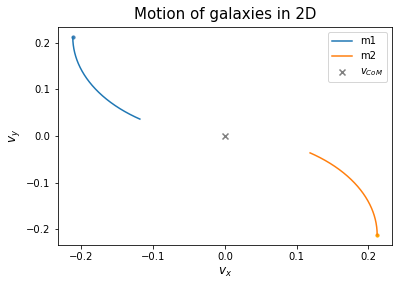

In [66]:
plt.scatter(0,0, marker='x', color='grey', label=r'$v_{CoM}$')
plt.scatter(v_[0,0], v_[0,1], s=10, c='steelblue') # initial velocity
plt.scatter(v_[0,2], v_[0,3], s=10, c='orange') # initial velocity
plt.plot(v_[:,0], v_[:,1], label="m1")
plt.plot(v_[:,2], v_[:,3], label="m2")
plt.title("Motion of galaxies in 2D", fontsize='15', y=1.01)
plt.legend()
plt.xlabel("$v_{x}$", fontsize=12), plt.ylabel("$v_y$", fontsize=12)




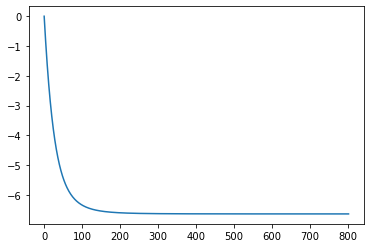

In [11]:
plt.plot(E)